# 8. Relación entre Aeropuertos - Aerolíneas. 

En este capítulo anterior se descubrieron las compañias aéreas y los aeropuertos donde los minutos de retraso promedio son mayores:

En este capítulo se analizan, para esos aeropuertos y compañias

1- los volúmenes de tráfico promedio

2- los ratios de:

- volumen de los vuelos totales, 
- volumen de vuelos retrasado 
- volumen de vuelos cancelados

## 8.1 Importación de librerías necesarias

Inicialmente se cargan las librerías de python necesarias.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pymongo import MongoClient

sns.set_style("darkgrid")

pd.options.display.float_format = '{:,.2f}'.format

## 8.2 Conexión con MONGO ATLAS / LOCAL

In [2]:
#Mongo Atlas
#URI ="mongodb://sato:<PASSWORD>@satoclusterfaa-shard-00-00-gst6h.\
#azure.mongodb.net:27017,satoclusterfaa-shard-00-01-gst6h.azure.\
#mongodb.net:27017,satoclusterfaa-shard-00-02-gst6h.azure.mongodb\
#.net:27017/test?ssl=true&replicaSet=SatoClusterFAA-shard-0&authSource=admin&retryWrites=true"

#client = MongoClient(URI)
#db = client.FAA_Airlines
#local
client = MongoClient()#"mongodb://localhost:27017")
db = client.airports

Se crea la variable **air** para facilitar las consultas.

In [3]:
air = db.airlines

## 8.3 Evolución histórica de Ratios Vuelos Puntuales, Retrasados y Cancelados respecto a Vuelos Totales por aerolínea WN, AA, EV, MQ y OO y aeropuerto de estudio LGA, ORD, EWR y SFO. 

En este apartado se va a extraer la evolución histórica, dentro del período de estudio, de los **ratios de vuelos puntuales, retrasados y cancelados respecto a los vuelos totales por aerolínea y aeropuerto de estudio**.

Para ello, se realiza la siguiente consulta en la que:

- se filtran los años de interés
- se agrupa por aerolínea, aeropuerto, año y mes
- en dicha agrupación, se calcula la suma de:

    - vuelos retrasados
    - vuelos cancelados
    - vuelos puntuales

- se crean los campos:

    - ratios vuelos retrasados
    - vuelos vuelos cancelados
    - vuelos vuelos puntuales
    

Además, de la consulta, se va a **generar una colección "Histórico_Aeropuertos_Aerolíneas"** para facilitar las consultas posteriores..

- **Query 29**

In [4]:
pipeline29 = [{"$match": {"time.year": {"$nin": [2003, 2016]}}},
             {"$group": {"_id": 
                        {"Aerolinea": "$carrier.code",
                         "Aeropuerto": "$airport.code",
                         "year": "$time.year", 
                         "month": "$time.month"},
                         "Totales": {"$sum": "$statistics.flights.total"},
                         "Retrasados": {"$sum": "$statistics.flights.delayed"},
                         "Cancelados": {"$sum": "$statistics.flights.cancelled"},
                         "Puntuales": {"$sum": "$statistics.flights.on time"}
                        }
             },
             {"$project": {
                          "Totales": "$Totales",  
                          "Ratio_Retrasados": {"$divide": ["$Retrasados", "$Totales"]},
                          "Ratio_Cancelados": {"$divide": ["$Cancelados", "$Totales"]},
                          "Ratio_Puntuales": {"$divide": ["$Puntuales", "$Totales"]}
                          }
             },
             {"$out": "Historico_Aeropuertos_Aerolineas"}
             
            ]

air.aggregate(pipeline29);

Se crea la variable **AA** para facilitar las consultas. 

In [5]:
#Se almacena la colección en una variable
AA = db.Historico_Aeropuertos_Aerolineas

Una vez obtenida la nueva colección, se procede a utilizarla.

## 8.4 Promedio de vuelos de las compañías WN, AA, EV, MQ y OO en los aeropuertos LGA, ORD, EWR y SFO durante los años de estudio. 

Con la siguiente consulta se pretende calcular el total premedio de vuelos en los años de estudio

- **Query 30**

In [6]:
pipeline30 = [{"$match": {"_id.Aeropuerto": {"$in": ["LGA", "ORD", "EWR", "SFO"]},
                          "_id.Aerolinea": {"$in": ["WN", "AA", "EV", "MQ", "OO"]}
                         }
              }, 
              {"$group": {"_id": {"Aeropuerto": "$_id.Aeropuerto", 
                                  "Aerolinea": "$_id.Aerolinea"}, 
                                  "Totales": {"$avg": "$Totales"}
                         }
              },
              {"$project": {"Aeropuerto": "$_id.Aeropuerto",
                            "Aerolinea": "$_id.Aerolinea",
                            "Totales": "$Totales",
                            "_id": 0
                           }
              }
             ]

curs30 = AA.aggregate(pipeline30)

In [7]:
query30 = list(curs30)

In [8]:
df30 = pd.DataFrame(query30).set_index(["Aerolinea", "Aeropuerto"]).unstack()
df30.index.name = "Aeropuerto"
df30.head(10)

Totales                           
Aeropuerto      EWR      LGA      ORD      SFO
Aeropuerto                                    
AA           477.36 1,568.11 5,439.27   993.18
EV         1,854.72   363.71 2,319.36    43.65
MQ           189.14 1,375.27 6,856.83   147.14
OO            77.44    16.93 3,061.15 3,598.30
WN           494.66   475.65      nan 1,211.98

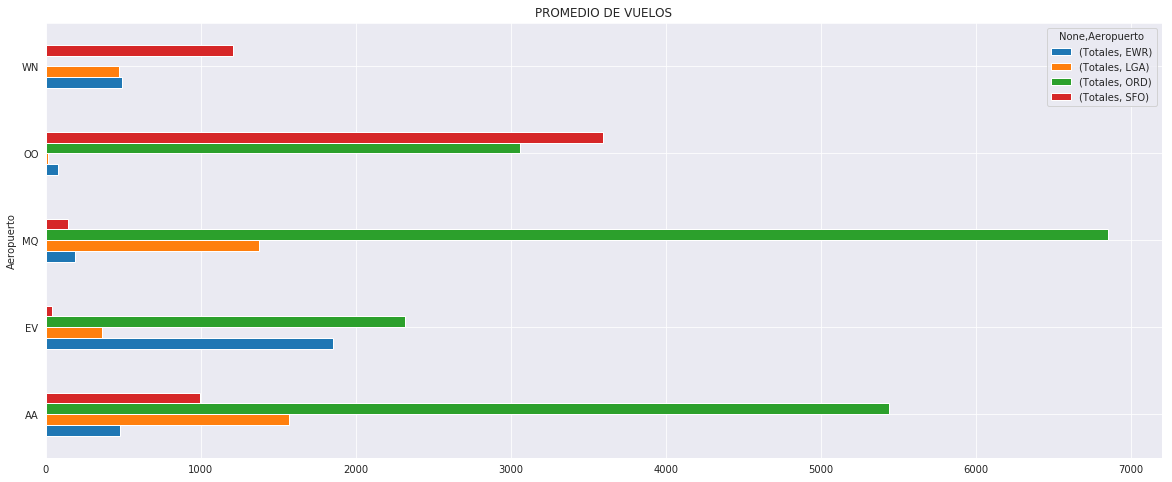

In [9]:
df30.plot(kind = "barh", figsize= (20,8), title = "PROMEDIO DE VUELOS");

Se aprecia que:

- Para las aerolíneas **AA, EV y MQ** las rutas con mayor volumen de vuelos promedio tienen origen y destino en ORL.
- Para las aerolíneas **OO y WN** las rutas con mayor volumen de vuelos promedio tienen origen y destino en SFQ.  

## 8.6 Combinaciones aeropuertos-aerolíneas con peores Ratios de Vuelos Puntuales, Retrasados y Cancelados respecto a Vuelos Totales. 

Partiendo de la colección creada, se plantéa la pregunta de cuáles son las combinaciones **aeropuertos-aerolíneas que peores Ratios medios han tenido**, durante los años de estudio.

Para esta pregunta se plantea la siguiente consulta.

- Se agupa por **aeropuerto y aerolínea**
- Se calculan los **ratios medios** 

- **Query 31**

In [10]:
pipeline31 = [{"$match": {"_id.Aeropuerto": {"$in": ["LGA", "ORD", "EWR", "SFO"]},
                          "_id.Aerolinea": {"$in": ["WN", "AA", "EV", "MQ", "OO"]}
                         }
              }, 
              {"$group": {"_id": {"Aeropuerto": "$_id.Aeropuerto", 
                                  "Aerolinea": "$_id.Aerolinea"}, 
                          "Ratio_Retrasados": {"$avg": "$Ratio_Retrasados"},
                          "Ratio_Cancelados": {"$avg": "$Ratio_Cancelados"},
                          "Ratio_Puntuales": {"$avg": "$Ratio_Puntuales"}
                         }
              },
              {"$project": {"Aeropuerto": "$_id.Aeropuerto",
                            "Aerolinea": "$_id.Aerolinea",
                            "Ratio_Retrasados": "$Ratio_Retrasados",
                            "Ratio_Cancelados": "$Ratio_Cancelados",
                            "Ratio_Puntuales": "$Ratio_Puntuales",
                            "_id": 0
                           }
              }
             ]

curs31 = AA.aggregate(pipeline31)

El cursor obtenido se convierte en lista y se almacena en una lista y se convierte el resultado en un dataframe. Se ofrece una vista de los 10 primeros aeropuertos.

In [11]:
query31 = list(curs31)

In [12]:
df31 = pd.DataFrame(query31).set_index(["Aeropuerto", "Aerolinea"]).unstack()
df31.index.name = "Aeropuerto"
df31.head(10)

Ratio_Cancelados                     Ratio_Puntuales            \
Aerolinea                AA   EV   MQ   OO   WN              AA   EV   MQ   
Aeropuerto                                                                  
EWR                    0.04 0.08 0.08 0.07 0.03            0.66 0.55 0.59   
LGA                    0.04 0.07 0.06 0.09 0.02            0.68 0.62 0.68   
ORD                    0.03 0.07 0.05 0.04  nan            0.74 0.67 0.71   
SFO                    0.02 0.04 0.04 0.03 0.03            0.69 0.59 0.75   

                     Ratio_Retrasados                      
Aerolinea    OO   WN               AA   EV   MQ   OO   WN  
Aeropuerto                                                 
EWR        0.49 0.67             0.30 0.35 0.33 0.41 0.30  
LGA        0.59 0.68             0.27 0.31 0.26 0.28 0.29  
ORD        0.72  nan             0.23 0.25 0.24 0.23  nan  
SFO        0.70 0.67             0.29 0.38 0.21 0.26 0.30

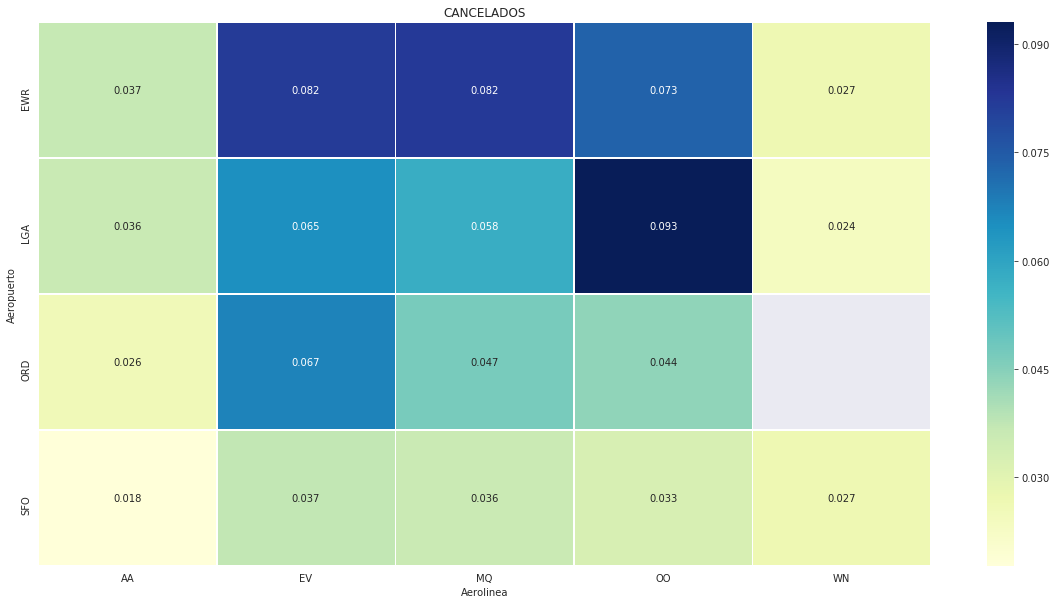

In [13]:
fig1, ax1 = plt.subplots(1, 1, figsize=(20,10));

ax1 = sns.heatmap(df31["Ratio_Cancelados"], annot=True, linewidths=.5, cmap="YlGnBu");
ax1.set_title("CANCELADOS");

Del gráfico anterior se aprecia:

- De los cuatro aeropuertos, las aerolínes que más cancelaciones han tenido son **EV, MQ y OO**.
- La que menos cancelaciones ha tenido son **AA y WN**.
- La aerolínea **WN no opera en el aeropuerto de ORD**.

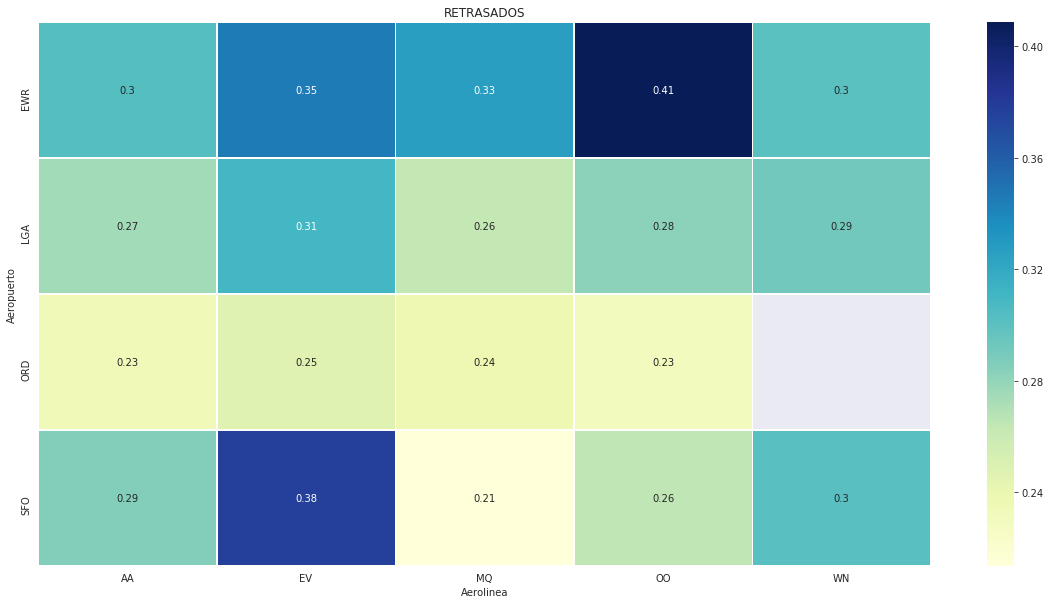

In [14]:
fig2, ax2 = plt.subplots(1, 1, figsize=(20, 10));

ax2 = sns.heatmap(df31["Ratio_Retrasados"], annot=True, linewidths=.5, cmap="YlGnBu");
ax2.set_title("RETRASADOS");

Se aprecia que:
    
- El aeropuerto con más retrasos son **EWR y LGA** y fundamentalmente debidos a las aerolíneas **OO y EV**
- El aeropuerto con menos retrasos para esas aerolíneas fue **ORL**  

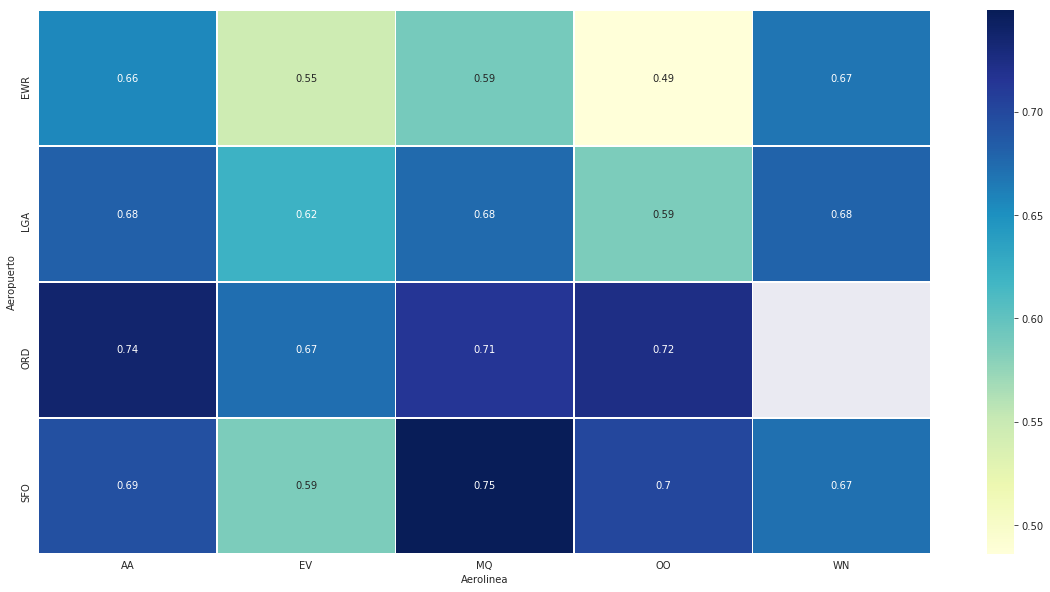

In [15]:
fig3, ax3 = plt.subplots(1, 1, figsize=(20,10));

ax3 = sns.heatmap(df31["Ratio_Puntuales"], annot=True, linewidths=.5, cmap="YlGnBu");
ax2.set_title("PUNTUALES");

Se aprecia que las combinaciones aeropuerto-aerolínea más puntuales han sido:

- **MQ-SFO**, 
- **AA-ORL**,
- **OO-ORD**

Como recordatorio se muesran a continuación los nombres de las compañias y aeropuertos junto a su código

- **Query 32. Compañías Aéreas**

In [16]:
curs32 = air.find(
                 {"carrier.code": {"$in": ["WN", "AA", "EV", "MQ", "OO"]}},
                 {"carrier.code": 1, "carrier.name": 1, "_id": 0}
)

In [17]:
query32 = list(curs32)

In [18]:
query32 = [(doc["carrier"]['code'], doc["carrier"]['name']) for doc in query32]
query32 = set(query32)

In [19]:
query32

{('AA', 'American Airlines Inc.'),
 ('EV', 'Atlantic Southeast Airlines'),
 ('EV', 'ExpressJet Airlines Inc.'),
 ('MQ', 'American Eagle Airlines Inc.'),
 ('MQ', 'Envoy Air'),
 ('OO', 'SkyWest Airlines Inc.'),
 ('WN', 'Southwest Airlines Co.')}

- **Query 33. Aeropuertos**

In [20]:
curs33 = air.find(
                 {"airport.code": {"$in": ["LGA", "ORD", "EWR", "SFO"]}},
                 {"airport.code": 1, "airport.name": 1, "_id": 0}
)

In [21]:
query33 = list(curs33)

In [22]:
query33 = [(doc["airport"]['code'], doc["airport"]['name']) for doc in query33]
query33 = set(query33)

In [23]:
query33

{('EWR', 'Newark, NJ: Newark Liberty International'),
 ('LGA', 'New York, NY: LaGuardia'),
 ('ORD', "Chicago, IL: Chicago O'Hare International"),
 ('SFO', 'San Francisco, CA: San Francisco International')}